# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [147]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [148]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS/2013/CFS_APCP_Basin_Sums.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS/2013/CFS_TMP_Basin_Avgs.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS/2013/CFS_EVAP_Basin_Sums.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Defined Functions

In [4]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [5]:
def convert_kg_to_cms(df):

    # Calculate the number of seconds for each month
    df['seconds'] = df.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # Convert millimeters to meters
    df['WaterErie_m3'] = df['WaterErie'] / 1000
    df['WaterOntario_m3'] = df['WaterOntario'] / 1000
    df['WaterSuperior_m3'] = df['WaterSuperior'] / 1000
    df['WaterMichHuron_m3'] = (df['WaterMichigan'] + df['WaterHuron']) / 1000

    # Convert the data to cubic meters per second
    df['WaterErie_cms'] = df['WaterErie_m3'] / df['seconds']
    df['WaterOntario_cms'] = df['WaterOntario_m3'] / df['seconds']
    df['WaterSuperior_cms'] = df['WaterSuperior_m3'] / df['seconds']
    df['WaterMichHuron_cms'] = df['WaterMichHuron_m3'] / df['seconds']
    
    return df

In [1]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    # Deleting column 'seconds'
    df_mm.drop('seconds', axis=1)

    return df_mm

In [149]:
# Read in GLCC RNBS data
data_4 = pd.read_csv(dir + 'Input/rnbs_glcc.csv', sep=',')

# Ensure 'Date' column is treated as string and modified as necessary
date_strs = data_4['Date'].astype(str)

date_rnbs = []

for date_str in date_strs:
    # Insert leading zero before month (if necessary)
    if len(date_str) == 6:
        date_str = date_str[:4] + '0' + date_str[4:]

    # Insert leading zero before day (if necessary)
    if len(date_str) == 7:
        date_str = date_str[:6] + '0' + date_str[6:]

    # Convert to datetime object
    datetime_obj = datetime.strptime(date_str, '%Y%m%d')

    # Format the datetime object as a string in the desired format
    date_tmp = datetime_obj.strftime('%Y-%m-%d')

    # Append formatted date to list
    date_rnbs.append(date_tmp)

# Replace the original 'Date' column with formatted dates
data_4['Date'] = date_rnbs

# Convert 'Date' column to datetime format
data_4['Date'] = pd.to_datetime(data_4['Date'])

# Add a new column 'Month' extracting month from 'Date'
data_4['Month'] = data_4['Date'].dt.month

# Select only the data that matches with the CFSR dates
start_date = '2013-01-01'
end_date = '2013-12-01'
obs = data_4[(data_4['Date'] >= start_date) & (data_4['Date'] <= end_date)]

su_rnbs = obs['sup']
er_rnbs = obs['eri']
on_rnbs = obs['ont']
mh_rnbs = obs['mic_hur']

In [150]:
print(obs)

           Date         sup    mic_hur         eri         ont  Month
1356 2013-01-01  -11.769590   53.17833   80.128480  179.297700      1
1357 2013-02-01    3.248239   83.02090  187.601300  197.372100      2
1358 2013-03-01   27.789320   87.79009   85.400090  176.496200      3
1359 2013-04-01  126.871200  308.55560  280.585700  347.027900      4
1360 2013-05-01  285.739600  207.21210   84.345770  172.293900      5
1361 2013-06-01  154.080400  135.31190  257.118600  321.271900      6
1362 2013-07-01  185.371100   70.59882  125.464300  114.862600      7
1363 2013-08-01  124.888500   41.94670  -12.651870   30.816800      8
1364 2013-09-01   64.859320  -11.75661  -88.767120    2.711155      9
1365 2013-10-01   45.116780   19.02501   -8.434577   84.045810     10
1366 2013-11-01   26.260120   70.98331   -1.020312  111.157400     11
1367 2013-12-01   16.346660   23.60935  139.170500  166.690900     12


## Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [151]:
# Convert Total Precipitation to cms
pcp_data = convert_kg_to_cms(pcp_data)

# Convert Total Evaporation to cms
evap_data = convert_kg_to_cms(evap_data)

In [152]:
print(pcp_data)

           cfsrun  year  month     BasinErie     WaterErie      LandErie  \
0      2013010100  2013      1  4.626504e+12  8.078905e+11  4.407254e+12   
1      2013010100  2013      2  4.549103e+12  7.660724e+11  4.401579e+12   
2      2013010100  2013      3  7.658135e+12  1.249122e+12  7.387767e+12   
3      2013010100  2013      4  1.053425e+13  1.708164e+12  1.006031e+13   
4      2013010100  2013      5  6.593253e+12  1.055659e+12  6.455295e+12   
...           ...   ...    ...           ...           ...           ...   
13895  2013123118  2014      5  4.655956e+12  7.497520e+11  4.493616e+12   
13896  2013123118  2014      6  7.847585e+12  1.252001e+12  7.684512e+12   
13897  2013123118  2014      7  1.190487e+13  2.055674e+12  1.126786e+13   
13898  2013123118  2014      8  7.274456e+12  1.098565e+12  7.377840e+12   
13899  2013123118  2014      9  2.942169e+12  4.579355e+11  2.862512e+12   

       BasinOntario  WaterOntario   LandOntario    BasinHuron  ...  \
0      5.016150e+

In [153]:
# Features
X = pd.DataFrame({
    'su_pcp': pcp_data['WaterSuperior_cms'],
    'er_pcp': pcp_data['WaterErie_cms'],
    'on_pcp': pcp_data['WaterOntario_cms'],
    'mh_pcp': pcp_data['WaterMichHuron_cms'], #data_1['WaterMichigan']+data_1['WaterHuron'], # add the sums
    'su_evap': evap_data['WaterSuperior_cms'],
    'er_evap': evap_data['WaterErie_cms'],
    'on_evap': evap_data['WaterOntario_cms'],
    'mh_evap': evap_data['WaterMichHuron_cms'], #data_2['WaterMichigan']+data_2['WaterHuron'], # add the sums
    'su_tmp': tmp_data['WaterSuperior'],
    'er_tmp': tmp_data['WaterErie'],
    'on_tmp': tmp_data['WaterOntario'],
    'mh_tmp': (tmp_data['WaterMichigan']+tmp_data['WaterHuron'])/2 # take the average temp
})

### Predict Components using GP
Scale the data and run it through the trained GP model. Put the results into a new dataframe.

In [154]:
# Predict RNBS using GP

# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['sup', 'eri', 'ont', 'mih'])
print(df_y_pred)

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


               sup          eri          ont          mih
0      -157.901337   771.252021  1124.546203  1083.249041
1        53.517930   923.222934   803.264647  1705.733478
2      -847.762363  1493.759487  1293.741158  1911.782238
3      1402.728440  2291.107636  2095.194466  5639.555463
4      1389.161681   355.972981   597.728430  1636.536232
...            ...          ...          ...          ...
13895   769.479392    64.933493   307.898130   703.392352
13896  2272.775440    71.318817   899.007999  2912.728024
13897   980.784733   511.219367   339.095302  1729.320742
13898  2736.517458   -86.311805    54.896343   577.824550
13899  2106.421692  -276.407877   240.773085    63.395165

[13900 rows x 4 columns]


In [155]:
df = pd.DataFrame()
df['cfsrun'] = pcp_data['cfsrun']
df['month'] = pcp_data['month'].astype(int)
df['year'] = pcp_data['year'].astype(int)

In [156]:
df_y = pd.merge(df, df_y_pred, left_index=True, right_index=True, how='inner')

In [157]:
print(df_y)

           cfsrun  month  year          sup          eri          ont  \
0      2013010100      1  2013  -157.901337   771.252021  1124.546203   
1      2013010100      2  2013    53.517930   923.222934   803.264647   
2      2013010100      3  2013  -847.762363  1493.759487  1293.741158   
3      2013010100      4  2013  1402.728440  2291.107636  2095.194466   
4      2013010100      5  2013  1389.161681   355.972981   597.728430   
...           ...    ...   ...          ...          ...          ...   
13895  2013123118      5  2014   769.479392    64.933493   307.898130   
13896  2013123118      6  2014  2272.775440    71.318817   899.007999   
13897  2013123118      7  2014   980.784733   511.219367   339.095302   
13898  2013123118      8  2014  2736.517458   -86.311805    54.896343   
13899  2013123118      9  2014  2106.421692  -276.407877   240.773085   

               mih  
0      1083.249041  
1      1705.733478  
2      1911.782238  
3      5639.555463  
4      1636.536232

Currently, we are only storing 1 set of model results

In [158]:
df_y.to_csv(dir+f'RNBS_forecasts_2013.csv',sep=',',index=False)

Convert component units from [cms] to [mm]

In [159]:
df_y_mm = convert_cms_to_mm(df_y)

In [160]:
def mean_min_max(df,lake):
    mean = df.groupby(['year', 'month'])[lake].median().reset_index()
    min = df.groupby(['year', 'month'])[lake].min().reset_index()
    max = df.groupby(['year', 'month'])[lake].max().reset_index()

    return mean, min, max

mean_su, min_su, max_su = mean_min_max(df_y_mm,'sup')
mean_er, min_er, max_er = mean_min_max(df_y_mm,'eri')
mean_on, min_on, max_on = mean_min_max(df_y_mm,'ont')
mean_mh, min_mh, max_mh = mean_min_max(df_y_mm,'mih')

In [161]:
df_y_mm_filtered = df_y_mm[(df_y_mm['year'] == 2013)]
print(df_y_mm_filtered)

           cfsrun  month  year        sup         eri         ont         mih  \
0      2013010100      1  2013  -5.151503   80.519252  158.450447   45.541042   
1      2013010100      2  2013   1.577044   87.057530  102.228304   64.771232   
2      2013010100      3  2013 -27.658096  155.949539  182.290300   80.373535   
3      2013010100      4  2013  44.287515  231.477334  285.693306  229.445255   
4      2013010100      5  2013  45.321152   37.163829   84.220939   68.801875   
...           ...    ...   ...        ...         ...         ...         ...   
13634  2013122318     12  2013  20.721517   46.467675   76.185429   89.869647   
13644  2013122400     12  2013   9.982661   61.815430   99.907753   94.503239   
13654  2013122406     12  2013  10.844342   18.684589   72.908497   82.632232   
13664  2013122412     12  2013  10.683713   23.123063   84.820268   87.719515   
13674  2013122418     12  2013  15.740513   10.962499   76.152590   76.879833   

       seconds  
0      267

Begin plotting

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

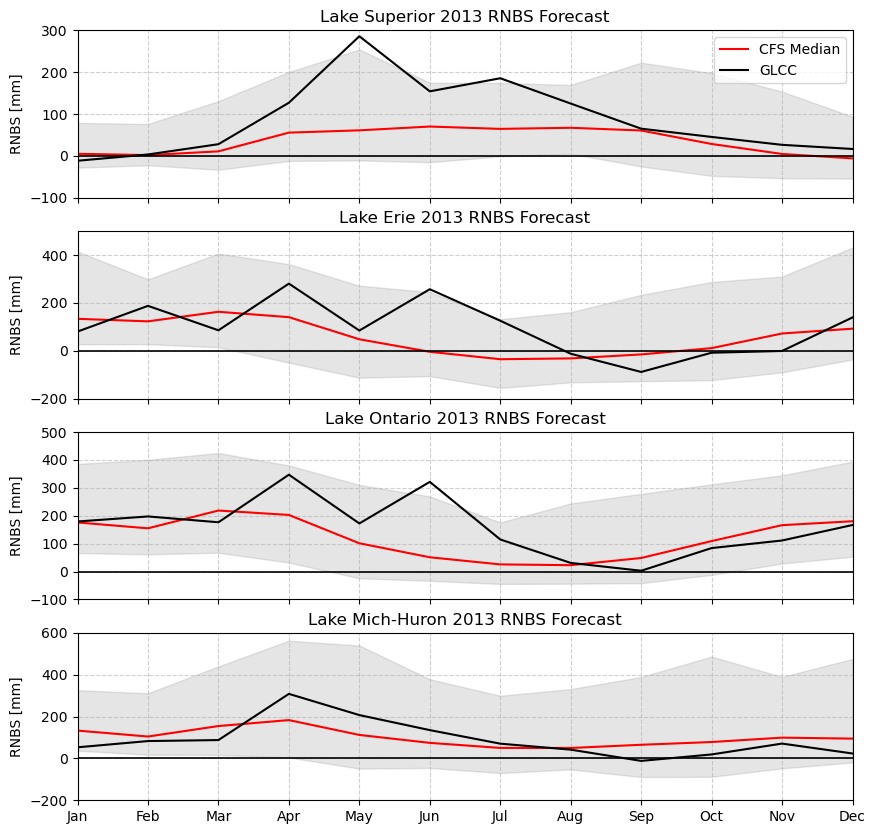

In [162]:
x_values = np.arange(0,12,1)  # x-axis values

# Creating a 4x1 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(x_values, mean_su['sup'][0:12], color='red', linestyle='-', linewidth=1.5, label='CFS Median')
axs[0].plot(x_values, su_rnbs, color='black', linestyle='-', linewidth=1.5, label='GLCC')
axs[0].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[0].fill_between(x_values, min_su['sup'][0:12], max_su['sup'][0:12], color='gray', alpha=0.2)
axs[0].set_ylabel('RNBS [mm]')
axs[0].set_title('Lake Superior 2013 RNBS Forecast')
axs[0].set_ylim(-100, 300)
axs[0].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[0].set_xticks(np.arange(0,12,1))
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].plot(x_values, mean_er['eri'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[1].plot(x_values, er_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[1].fill_between(x_values, min_er['eri'][0:12], max_er['eri'][0:12], color='gray', alpha=0.2)
axs[1].set_ylabel('RNBS [mm]')
axs[1].set_title('Lake Erie 2013 RNBS Forecast')
axs[1].set_ylim(-200, 500)
axs[1].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[1].set_xticks(np.arange(0,12,1))
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[2].plot(x_values, mean_on['ont'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[2].plot(x_values, on_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[2].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[2].fill_between(x_values, min_on['ont'][0:12], max_on['ont'][0:12], color='gray', alpha=0.2)
axs[2].set_ylabel('RNBS [mm]')
axs[2].set_title('Lake Ontario 2013 RNBS Forecast')
axs[2].set_ylim(-100, 500)
axs[2].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[2].set_xticks(np.arange(0,12,1))
axs[2].grid(True, linestyle='--', alpha=0.6)

axs[3].plot(x_values, mean_mh['mih'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[3].plot(x_values, mh_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[3].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[3].fill_between(x_values, min_mh['mih'][0:12], max_mh['mih'][0:12], color='gray', alpha=0.2)
axs[3].set_ylabel('RNBS [mm]')
axs[3].set_title('Lake Mich-Huron 2013 RNBS Forecast')
axs[3].set_ylim(-200, 600)
axs[3].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[3].set_xticks(np.arange(0,12,1))
axs[3].grid(True, linestyle='--', alpha=0.6)
axs[3].set_xticklabels([calendar.month_abbr[mean_mh['month'][j]] for j in range(12)])

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\3470780165.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\3470780165.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


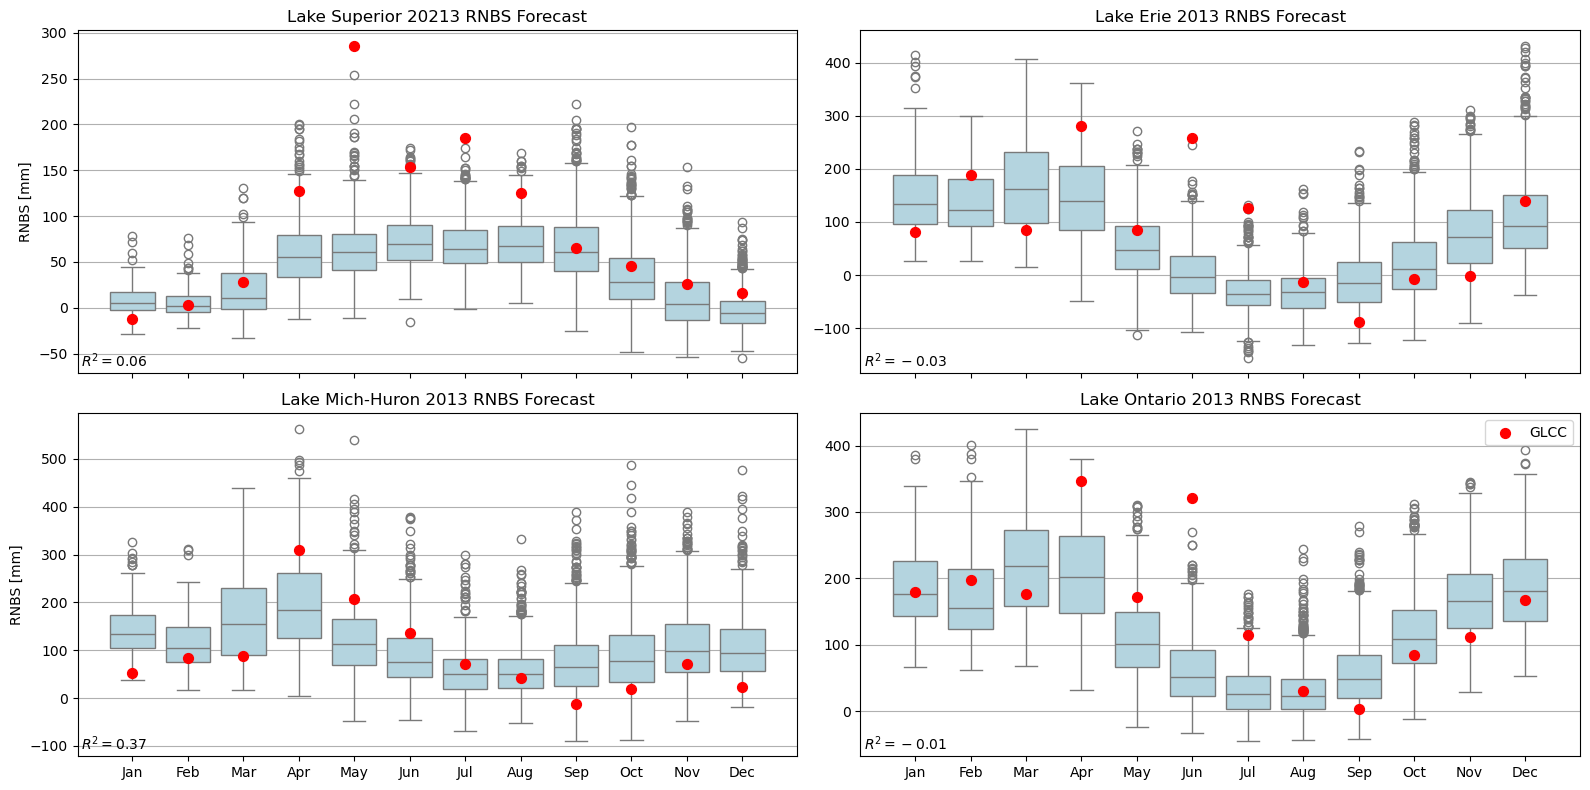

In [163]:
import seaborn as sns
from sklearn.metrics import r2_score

months = np.arange(0, 12)

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# First boxplot
sns.boxplot(x='month', y='sup', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 0])
axes[0, 0].set_title('Lake Superior 2013 RNBS Forecast')
# Scatter plot for observations
axes[0, 0].scatter(obs['Month']-1, obs['sup'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 0].set_ylabel('RNBS [mm]')
axes[0, 0].set_xlabel('')
axes[0, 0].set_xticklabels('')
axes[0, 0].grid(axis='y')

r2_1 = r2_score(obs['sup'],df_y_mm_filtered.groupby('month')['sup'].median())
axes[0, 0].text(0.005, 0.009, f'$R^2 = {r2_1:.2f}$', ha='left', va='bottom', transform=axes[0, 0].transAxes)

# Second boxplot
sns.boxplot(x='month', y='eri', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 1])
axes[0, 1].set_title('Lake Erie 2013 RNBS Forecast')
# Scatter plot for observations
axes[0, 1].scatter(obs['Month']-1, obs['eri'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].set_xticklabels('')
axes[0, 1].grid(axis='y')

r2_2 = r2_score(obs['eri'],df_y_mm_filtered.groupby('month')['eri'].median())
axes[0, 1].text(0.005, 0.009, f'$R^2 = {r2_2:.2f}$', ha='left', va='bottom', transform=axes[0, 1].transAxes)

# Third boxplot
sns.boxplot(x='month', y='mih', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 0])
axes[1, 0].set_title('Lake Mich-Huron 2013 RNBS Forecast')
# Scatter plot for observations
axes[1, 0].scatter(obs['Month']-1, obs['mic_hur'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 0].set_ylabel('RNBS [mm]')
axes[1, 0].set_xlabel('')
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 0].grid(axis='y')

r2_3 = r2_score(obs['mic_hur'],df_y_mm_filtered.groupby('month')['mih'].median())
axes[1, 0].text(0.005, 0.009, f'$R^2 = {r2_3:.2f}$', ha='left', va='bottom', transform=axes[1, 0].transAxes)

# Fourth boxplot
sns.boxplot(x='month', y='ont', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 1])
axes[1, 1].set_title('Lake Ontario 2013 RNBS Forecast')
# Scatter plot for observations
axes[1, 1].scatter(obs['Month']-1, obs['ont'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('')
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 1].grid(axis='y')
axes[1, 1].legend()

r2_4 = r2_score(obs['ont'],df_y_mm_filtered.groupby('month')['ont'].median())
axes[1, 1].text(0.005, 0.009, f'$R^2 = {r2_4:.2f}$', ha='left', va='bottom', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

In [164]:
# Calculate important statistics
stats = df_y_mm_filtered.groupby('month')['mih'].describe()
print("Important values:\n", stats)

Important values:
         count        mean        std        min         25%         50%  \
month                                                                     
1        96.0  147.561776  65.129004  37.151777  105.544173  133.049028   
2       212.0  113.921754  53.589853  17.549025   75.995269  104.633857   
3       324.0  166.229172  91.657843  16.774826   89.683861  154.784663   
4       448.0  200.058484  98.638856   4.909243  125.499832  183.181960   
5       564.0  126.100136  80.623030 -48.755846   68.451523  112.291809   
6       672.0   89.702666  68.600178 -45.278379   43.306190   74.403928   
7       788.0   56.095150  52.125485 -69.819651   19.790410   50.185117   
8       912.0   57.301317  51.322189 -52.470353   21.981044   49.941617   
9      1036.0   74.422424  72.293883 -89.071502   25.081591   65.263563   
10     1156.0   90.218165  79.982790 -87.735831   34.248795   78.391561   
11     1156.0  109.171865  77.758431 -47.335164   53.952417   99.378338   
12    